<a href="https://colab.research.google.com/github/LizLian/from_scratch_2025/blob/main/Activation%26Gradients%26BatchNorm_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Grandients

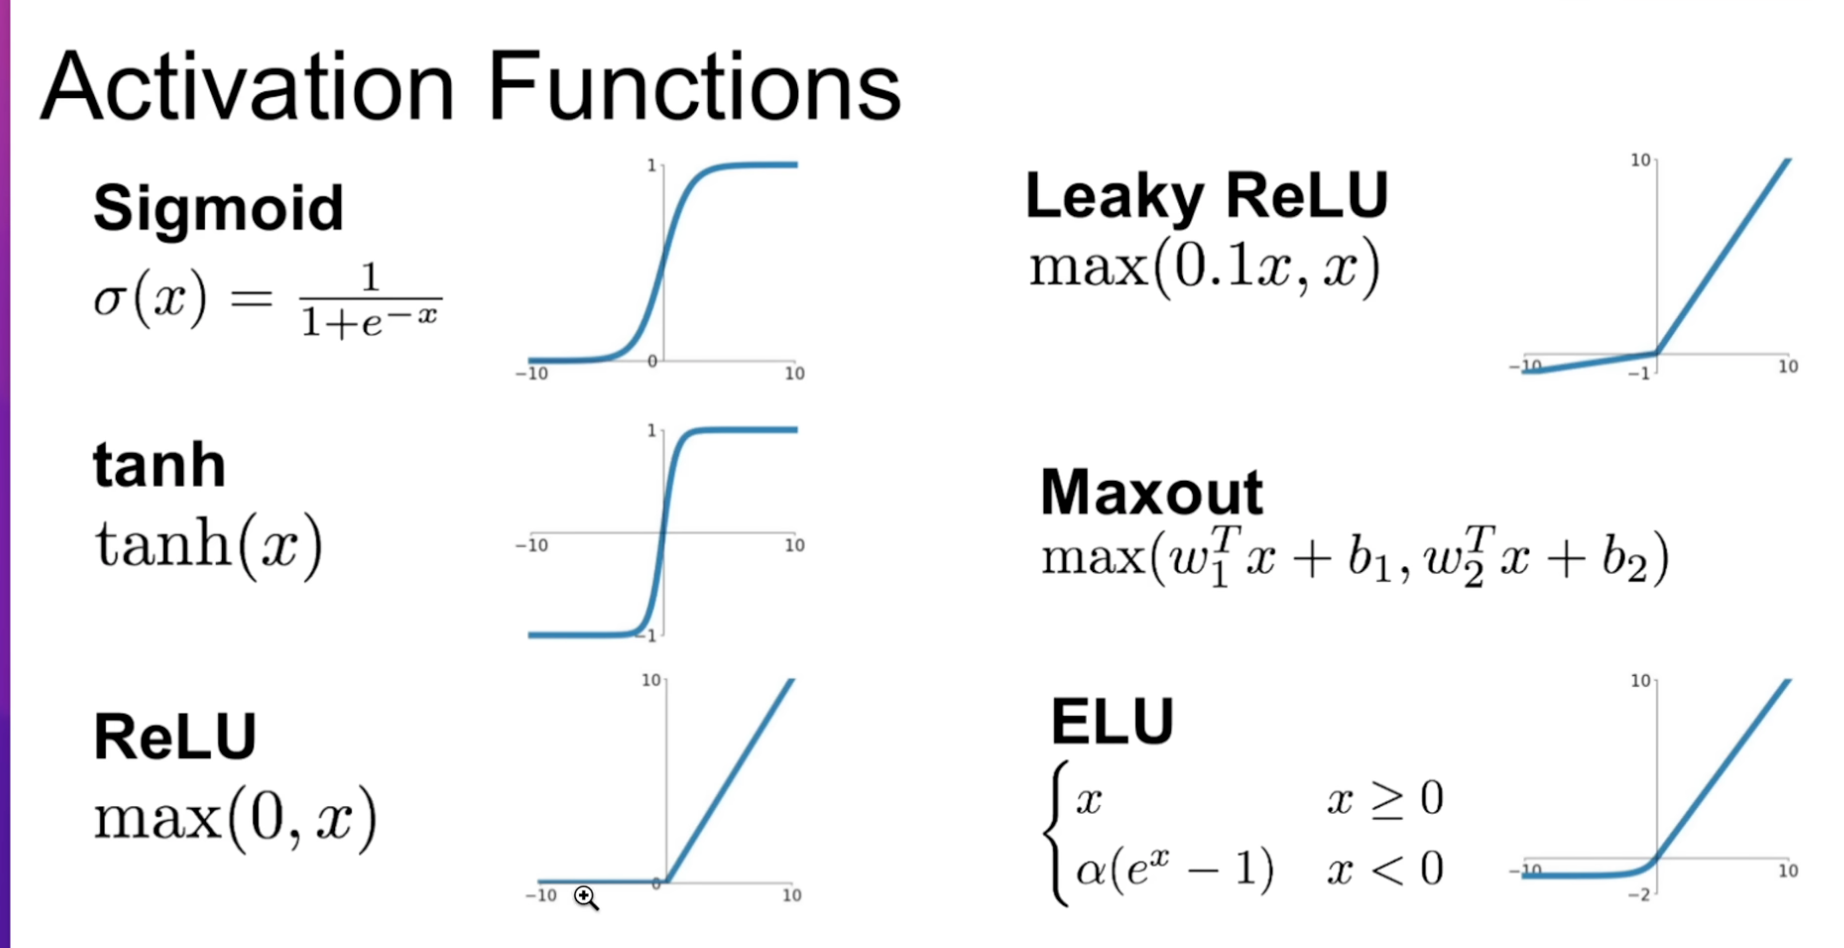

Vanishing gradients: tanh activation function d(tanh)/d(x) = (1-tanh**2),
self.grad = (1-tanh**2) * out.grad. if tanh is close to -1 or 1, the gradient after the activation function is going to be 0.

Sigmoid, tanh and ReLU have the same issues (at the flat region).




In [5]:
block_size = 3
data = []
with open("names.txt") as infile:
  for line in infile:
    data.append(line.strip())

vocab = set(".".join(data))
stoi = {}
itos = {}
for i, c in enumerate(sorted(vocab)):
  stoi[c] = i
  itos[i] = c


def build_dataset(data):
  context = [0] * block_size # print(stoi["."])
  X, Y = [], []
  for name in data:
    for c in name + ".":
      ix = stoi[c]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  return X, Y


Xtr, Ytr = build_dataset(data[:int(len(data) * 0.8)])
Xdev, Ydev = build_dataset(data[int(len(data) * 0.8): int(len(data) * 0.9)])
Xtest, Ytest = build_dataset(data[int(len(data) * 0.9): ])

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [20]:
import random
g = torch.Generator().manual_seed(2147483647)
emb = torch.randn(size=(27, 100), generator=g)
W1 = torch.randn(size=(300, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(size=(100, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [emb, W1, b1, W2, b2]
for param in params:
  param.requires_grad = True

In [13]:
# @title Training Loop
Xtr = torch.tensor(Xtr)
Ytr = torch.tensor(Ytr)
stepi = []
lossi = []
batch_size = 32

for i in range(100):
  mini_batch = torch.randint(0, len(Xtr), size=(batch_size,))
  x = Xtr[mini_batch]
  y = Ytr[mini_batch]
  h = torch.tanh(emb[x].view(mini_batch.shape[0],-1) @ W1 + b1)
  logits = h@W2 + b2
  loss = F.cross_entropy(logits, y)

  # backward loss
  for param in params:
    param.grad = None
  loss.backward()

  lr = 0.1 if i < 100000 else 0.01
  for param in params:
    param.data += -lr * param.grad

  stepi.append(i)
  lossi.append(loss.item())
  break
print(loss.item())

16.094703674316406


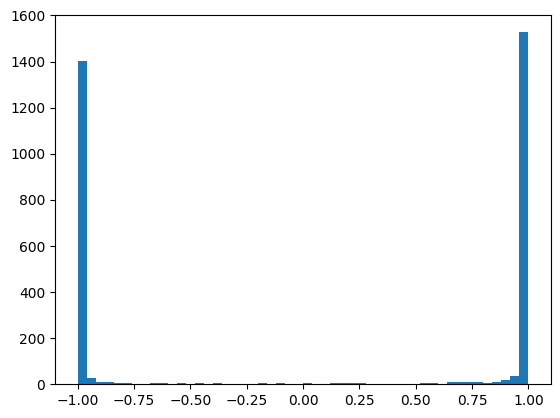

In [15]:
plt.hist(h.view(-1).tolist(), 50);
# The gradient is close to 0 if the value of h is close to -1 or 1.

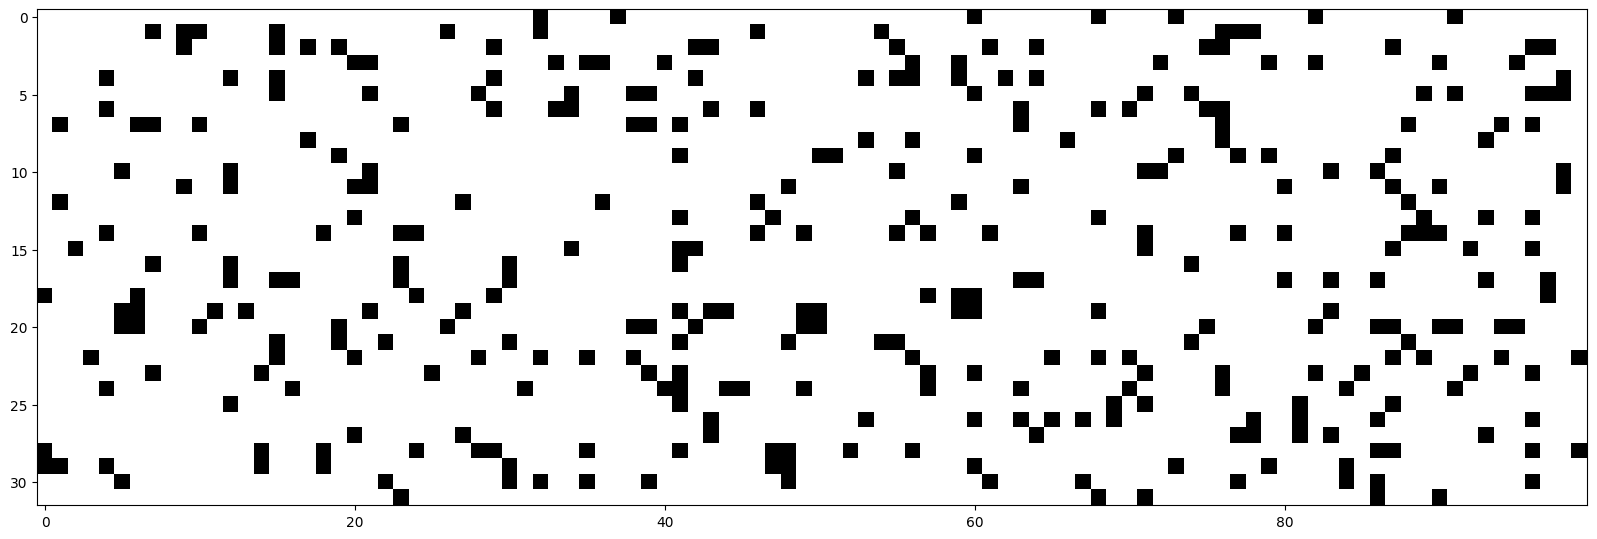

In [18]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap="gray", interpolation="nearest")
# the gradient of the white part is 0. If the entire batch is white, that is a dead neuron.
# Solution: rescale the value of hpreact to close to 0. (Please implement the solution)
# See how this chart changes after the implementation.

In [23]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      "train": (Xtr, Ytr),
      "val": (Xdev, Ydev),
      "test": (Xtest, Ytest)
  }[split]
  x_emb = emb[x]
  embcat = x_emb.view(x_emb.shape[0], -1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

Xtr = torch.tensor(Xtr)
Ytr = torch.tensor(Ytr)
Xdev = torch.tensor(Xdev)
Ydev = torch.tensor(Ydev)
split_loss("train")
split_loss("val")

/tmp/ipython-input-1023662169.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtr = torch.tensor(Xtr)
/tmp/ipython-input-1023662169.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ytr = torch.tensor(Ytr)


train 20.090715408325195
val 20.35532569885254


##Log loss

original:
train
val

fix softmax confidently wrong:
train
val

fix tanh layer too saturated at init:
train
val


In [25]:

# @title A scientific way of initializing the weights
# Kaiming normalization paper: https://arxiv.org/pdf/1502.01852
  # keep the distribution of y's (y = x @ w) mean and std to 0 and 1.
  # https://docs.pytorch.org/docs/stable/nn.init.html (kaiming_normal_), gain for tanh=5/3, std = gain/sqrt(fan_in)


In [26]:
# @title Batch Normalization
# paper: https://arxiv.org/pdf/1502.03167

Normalize hidden state to be gassian

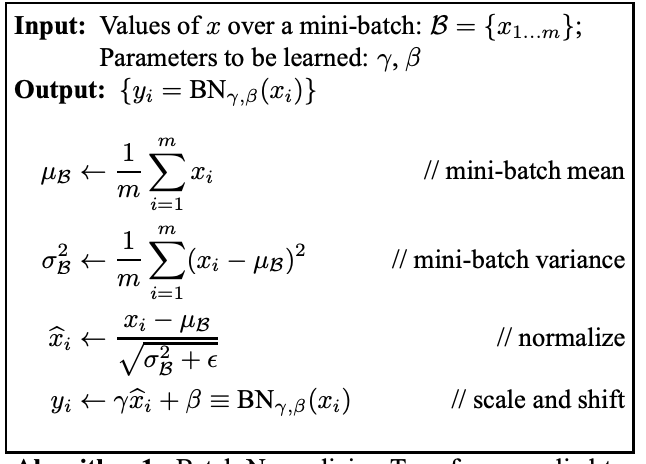

1. in the training loop, normalize mean and std of hpreact (h preactivation)
hpreact = bngain * (hpreact - bnmean)/bnstd + bnbias
2. compute bnmean and bnstd of the entire training set, use this bnmean and bnstd in eval.
3. emit step 2, compute bnmean_running and bnstd_running in the training loop (no grad), use these in eval.
bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
(hint: keep most of the bnmean, and incorporate some bnmeani.)

In [ ]:
# implementation

In [27]:
#  @title Pytorch-fying the above implemntation


1. create a linear class
*   initalize the weight and bias.
*   compuate self.out in __call__
* add weight and bias to parameters







In [28]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    # self.weight =  #impelemnt kaiming normalization
    # self.bias =
    pass

  def __call__(self, x):
    pass

  def parameters(self):
    pass

class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.training = True
    # self.gamma =
    # self.beta =

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      pass
    else:
      pass

  def parameters(self):
    return [self.gemma, self.beta]


class Tanh:
  def __call__(self, x):
    pass

  def parameters(self):
    return []

In [29]:
# @title Initialize the network.
# create a layers variable with 6 layers

In [30]:
# @title visualize histograms (out)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

NameError: name 'layers' is not defined

<Figure size 2000x400 with 0 Axes>

In [ ]:
# @title visualize histograms (gradient)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# Why do we need tanh?
If we have multiple linear layers, it's still a linear transformation.
tanh non-linearity can approximate any abitrary function.

In [31]:
# @title Visualize weights
# data ratio: the scale of the gradients compare the scale of the acutal values
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

NameError: name 'parameters' is not defined

<Figure size 2000x400 with 0 Axes>

In [ ]:
# @title Visualize the update to data ratio
# (lr*p.grad).std()/p.data.std()
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);